# Data Mining Project 
### Group A - 2019/2020 

## Report: Customer Segmentation for an Insurance Company’s Marketing Department 


Authors
Dave Montali - M20190201 
Gustavo Fabricio - M20190129 
Philipp Tueschen - M20180391 


# 1. Packages

Please Run the cell below to install packages not typically included with the conda environment. The cell below will install the ipywidgets factor_analyzer kmodes python modules, ensuring the rest of the notebook runs smoothly. The cell will also import all other libraries included in conda which we use in the notebook.

In [47]:
import sqlalchemy as sqla
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from ipywidgets import interact, interact_manual
from sklearn import preprocessing
from sklearn.preprocessing import QuantileTransformer
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import DBSCAN

from sklearn.decomposition import PCA

from kmodes.kmodes import KModes
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

from scipy.cluster.hierarchy import dendrogram, linkage#, set_link_color_pallete
from scipy.cluster import hierarchy

# 2. Import Data Frame 

In [48]:
df_database = pd.read_csv('https://raw.githubusercontent.com/GustavoFabricio/Insurance_Project/master/A2Z%20Insurance.csv')
df_database = df_database.rename(index=str, columns = {'Customer Identity': "CustomerIdentity",
                                                       'Premiums in LOB: Motor': 'P_Motor',
                                                       'Premiums in LOB: Household': 'P_Household',
                                                       'Premiums in LOB: Health': 'P_Health',
                                                       'Premiums in LOB:  Life': 'P_Life',
                                                       'Premiums in LOB: Work Compensations': 'P_Work',
                                                       'First Policy´s Year': 'FirstPolicy',
                                                       'Brithday Year': 'BirthdayYear',
                                                       'Educational Degree': 'EducationalDegree',
                                                       'Gross Monthly Salary': 'GrossMonthlySalary',
                                                       'Geographic Living Area': 'GeographicLivingArea', 
                                                       'Has Children (Y=1)': 'Children',
                                                       'Customer Monetary Value': 'CustomerMonetaryValue',
                                                       'Claims Rate': 'ClaimsRate'})
df_database.head(5)

,CustomerIdentity,FirstPolicy,BirthdayYear,EducationalDegree,GrossMonthlySalary,GeographicLivingArea,Children,CustomerMonetaryValue,ClaimsRate,P_Motor,P_Household,P_Health,P_Life,P_Work
0,1,1985.0,1982.0,2 - High School,2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
1,2,1981.0,1995.0,2 - High School,677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
2,3,1991.0,1970.0,1 - Basic,2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
3,4,1990.0,1981.0,3 - BSc/MSc,1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
4,5,1986.0,1973.0,3 - BSc/MSc,1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45


# 3. Exploring the data

In [49]:
# number of rows and columns
print(f'Number of Rows: {df_database.shape[0]}\nNumber of Cols:{df_database.shape[1]}')

# data types within the dataframe
print(f'\nDataFrame Variable data types: \n{df_database.dtypes}')

Number of Rows: 10296
Number of Cols:14

DataFrame Variable data types: 
CustomerIdentity           int64
FirstPolicy              float64
BirthdayYear             float64
EducationalDegree         object
GrossMonthlySalary       float64
GeographicLivingArea     float64
Children                 float64
CustomerMonetaryValue    float64
ClaimsRate               float64
P_Motor                  float64
P_Household              float64
P_Health                 float64
P_Life                   float64
P_Work                   float64
dtype: object


In [50]:
#Get thebest insights
print(f'DataFrame Summary by Numerical Variables: \n{df_database.describe()}')

DataFrame Summary by Numerical Variables: 
       CustomerIdentity   FirstPolicy  BirthdayYear  GrossMonthlySalary  \
count       10296.00000  10266.000000  10279.000000        10260.000000   
mean         5148.50000   1991.062634   1968.007783         2506.667057   
std          2972.34352    511.267913     19.709476         1157.449634   
min             1.00000   1974.000000   1028.000000          333.000000   
25%          2574.75000   1980.000000   1953.000000         1706.000000   
50%          5148.50000   1986.000000   1968.000000         2501.500000   
75%          7722.25000   1992.000000   1983.000000         3290.250000   
max         10296.00000  53784.000000   2001.000000        55215.000000   

       GeographicLivingArea      Children  CustomerMonetaryValue  \
count          10295.000000  10275.000000           10296.000000   
mean               2.709859      0.706764             177.892605   
std                1.266291      0.455268            1945.811505   
min      

In [51]:
# how many empty cells by column
print(f'Total NA by Column: \n\n{df_database.isna().sum()}')

#how many empty cells by row
print(f'\n\nTotal NA by Row: \n\n{df_database.isnull().sum(axis =1).value_counts(ascending= True)}') 

Total NA by Column: 

CustomerIdentity           0
FirstPolicy               30
BirthdayYear              17
EducationalDegree         17
GrossMonthlySalary        36
GeographicLivingArea       1
Children                  21
CustomerMonetaryValue      0
ClaimsRate                 0
P_Motor                   34
P_Household                0
P_Health                  43
P_Life                   104
P_Work                    86
dtype: int64


Total NA by Row: 

3       3
4      12
2      38
1     256
0    9987
dtype: int64


In [52]:
#for null values of the insurance we will assume that the customer does not own the product
df_database.fillna(value={'P_Motor': 0, 'P_Health': 0, 'P_Life': 0, 'P_Work': 0}, inplace = True)
#Change Education Labels
df_database.replace(to_replace={'2 - High School':2,'1 - Basic':1,'3 - BSc/MSc':3,'4 - PhD':4}, inplace=True)

## 3.1 Data Distribution and cleaning inconsistent values

In [53]:
@interact
def plt_distro(indicator=['P_Motor', 'P_Household', 'P_Health', 'P_Life', 'P_Work', 'FirstPolicy', 
                          'BirthdayYear','GrossMonthlySalary', 'CustomerMonetaryValue', 'ClaimsRate']):
    plt.figure(figsize=(15,5))
    return sb.boxplot(np.array(df_database[indicator].dropna())) 
  

interactive(children=(Dropdown(description='indicator', options=('P_Motor', 'P_Household', 'P_Health', 'P_Life…

#### As we can see, our database has outiliers and/or some wrong informations for all variables


In [54]:
# [FirstPolicy] let's replace the inconsistent value  53784
df_database['FirstPolicy'].replace(53784, None, inplace=True)

# [BirthdayYear] Let's assume that nobody can be born before 1920 and input null values for this cases.
df_database['BirthdayYear'] = df_database['BirthdayYear'].apply(lambda x: x if x > 1920 else None)

#['BirthdayYear'] Nobody can have a Policy before they were born so let's put Null for Birthday years after the first policy
df_database.loc[df_database['BirthdayYear'] > df_database['FirstPolicy'], 'BirthdayYear'] = None


In [55]:
@interact
def plt_distro(indicator=['EducationalDegree','GeographicLivingArea','Children']):
    plt.figure(figsize=(10,7))
    return sb.barplot(x=indicator, y="CustomerIdentity", data=df_database.groupby(indicator)['CustomerIdentity'].count().reset_index())



interactive(children=(Dropdown(description='indicator', options=('EducationalDegree', 'GeographicLivingArea', …

## 4. Removing Outliers

In [56]:
#to look for outliers, we will standardize the variables in order to put then at the same scale
dbScaled = pd.concat([df_database['P_Motor'], df_database['P_Household'], df_database['P_Health'], 
                            df_database['P_Life'], df_database['P_Work'],df_database['GrossMonthlySalary'], 
                            df_database['CustomerMonetaryValue'], df_database['ClaimsRate']], axis =1)

mm_scaler = preprocessing.MinMaxScaler()
dbScaled = pd.DataFrame(mm_scaler.fit_transform(dbScaled), 
                              columns = ['P_Motor', 'P_Household', 'P_Health', 'P_Life', 'P_Work',
                                         'GrossMonthlySalary', 'CustomerMonetaryValue', 'ClaimsRate'], 
                              index = df_database.index)

# Tryng to transform the distributions more similar as a normal distribution we applyed Square root
for x in dbScaled.columns :
    dbScaled[x] = (dbScaled[x]+0.0001)**0.5

In [57]:
@interact
def plt_distro(indicator=['P_Motor', 'P_Household', 'P_Health', 'P_Life', 'P_Work','GrossMonthlySalary', 'CustomerMonetaryValue', 'ClaimsRate']):
    plt.figure(figsize=(15,5))
    return sb.boxplot(np.array(dbScaled[indicator]))

interactive(children=(Dropdown(description='indicator', options=('P_Motor', 'P_Household', 'P_Health', 'P_Life…

#### Because we still have distributions with a long tail on right or left side we decide to adapt the Box Plot fomula to find possible outliers, instead of use quantile .25 and .75 we use .2 and .8 and instead of multiply for 1.5 we will multiply for 2.5

In [58]:
dbScaledOutliers = pd.DataFrame(columns = ['P_Motor', 'P_Household', 'P_Health', 'P_Life', 'P_Work',
                                      'GrossMonthlySalary', 'CustomerMonetaryValue', 'ClaimsRate'])

for variable in dbScaled.columns:
    IQR = (dbScaled[variable].quantile(0.8) - dbScaled[variable].quantile(0.2))
    LS = dbScaled[variable].quantile(0.8) + IQR*2.5
    LI = dbScaled[variable].quantile(0.2) - IQR*2.5
    dbScaledOutliers = pd.concat([dbScaledOutliers, dbScaled[(dbScaled[variable] < LI) | (dbScaled[variable] > LS)]])

dbScaledOutliers.drop_duplicates(keep='last', inplace = True)
dbScaled = dbScaled.drop(list(dbScaledOutliers.index))
df_databaseOutliers =  df_database.loc[df_database.index.isin(dbScaledOutliers.index)]  
df_database = df_database.drop(list(dbScaledOutliers.index))

In [59]:
print('At the end we removed', len(df_databaseOutliers), 'at total \n\n' )
df_databaseOutliers.head()

At the end we removed 40 at total 




,CustomerIdentity,FirstPolicy,BirthdayYear,EducationalDegree,GrossMonthlySalary,GeographicLivingArea,Children,CustomerMonetaryValue,ClaimsRate,P_Motor,P_Household,P_Health,P_Life,P_Work
51,52,1982.0,1966.0,3.0,3234.0,4.0,1.0,-14714.08,25.36,557.44,20.00,29.56,5.00,-9.00
112,113,1997.0,1979.0,4.0,2354.0,1.0,1.0,-8719.04,15.65,518.32,4.45,55.90,3.89,10.89
135,136,1997.0,1988.0,3.0,2176.0,4.0,1.0,-10198.91,14.80,297.61,162.80,143.36,136.47,-3.00
149,150,1989.0,NaN,1.0,984.0,4.0,1.0,255.71,0.63,64.90,197.25,29.56,18.56,451.53
171,172,1990.0,1989.0,3.0,1086.0,4.0,1.0,-165680.42,256.20,378.07,78.90,166.81,6.89,18.45


## 4.1 Distribution after remove Outliers

In [60]:
@interact
def plt_distro(indicator=['P_Motor', 'P_Household', 'P_Health', 'P_Life', 'P_Work','GrossMonthlySalary', 'CustomerMonetaryValue', 'ClaimsRate']):
    plt.figure(figsize=(15,5))
    return sb.boxplot(np.array(df_database[indicator]))

interactive(children=(Dropdown(description='indicator', options=('P_Motor', 'P_Household', 'P_Health', 'P_Life…

# 5. Deal with null data

## 5.1 Correlation

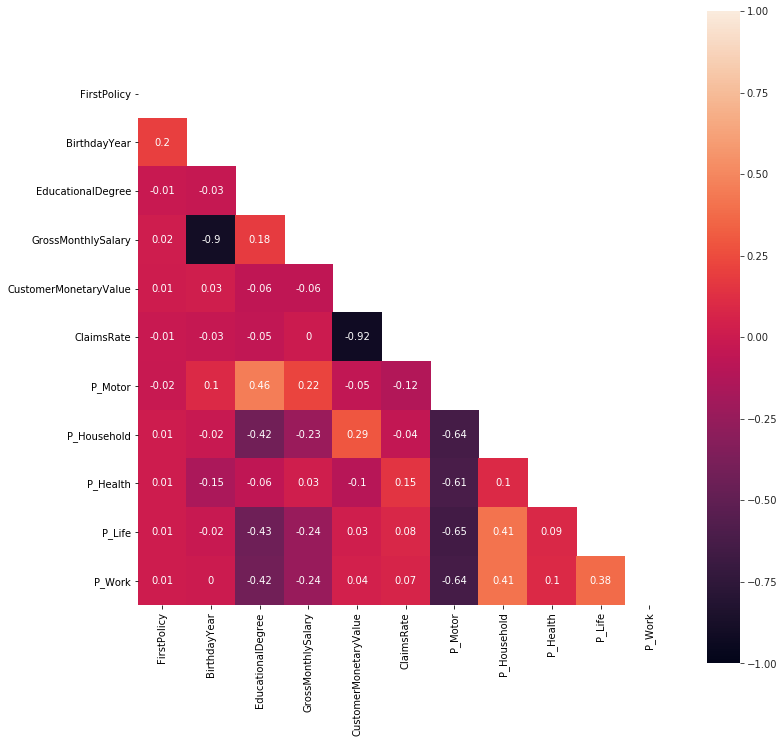

In [61]:
#Before deal with the null data we will take a look at the correlation between numerical variables
corr = df_database.drop(['Children', 'GeographicLivingArea', 'CustomerIdentity'], axis=1).corr(method='pearson').round(2)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(12,12))
with sb.axes_style("white"):
    ax = sb.heatmap(corr, annot=True,mask=mask, vmax=1, vmin=-1, square=True)
# OBS: We can notice Growth Salary has a strong negative correlation with birthday year and Old people has best salaries
#      Costumer monetary value has a strong negative correlation with Clains Rate  if Clains Rate is High te custumer monetary is low



In [62]:
print("% of null Values \n", (df_database.isna().sum()/len(df_database))*100)

% of null Values 
 CustomerIdentity          0.000000
FirstPolicy               0.292512
BirthdayYear             19.491030
EducationalDegree         0.165757
GrossMonthlySalary        0.351014
GeographicLivingArea      0.009750
Children                  0.204758
CustomerMonetaryValue     0.000000
ClaimsRate                0.000000
P_Motor                   0.000000
P_Household               0.000000
P_Health                  0.000000
P_Life                    0.000000
P_Work                    0.000000
dtype: float64


#### As we can see, apart from Brithday year the others variables has less than 1% of null values

## 5.2 Predicting GeographicLivingArea, GrossMonthlySalary and FirstPolicy with Most frequent Value 

In [63]:
#GeographicLivingArea, GrossMonthlySalary, FirstPolicy we will apply the most commum value to replace the NA

imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df_database['EducationalDegree'] = imp_mode.fit_transform(df_database[['EducationalDegree']]).ravel()
####GeographicLivingArea
df_database['GeographicLivingArea'] = imp_mode.fit_transform(df_database[['GeographicLivingArea']]).ravel()
####GrossMonthlySalary
df_database['GrossMonthlySalary'] = imp_mode.fit_transform(df_database[['GrossMonthlySalary']]).ravel()
####FirstPolicy
df_database['FirstPolicy'] = imp_mode.fit_transform(df_database[['FirstPolicy']]).ravel()

In [64]:
# Because we estimate FirstPolicy lets check Again check for birthdays grather than first policy
df_database.loc[df_database['BirthdayYear'] > df_database['FirstPolicy'], 'BirthdayYear'] = None
df_database.isna().sum()

CustomerIdentity            0
FirstPolicy                 0
BirthdayYear             2002
EducationalDegree           0
GrossMonthlySalary          0
GeographicLivingArea        0
Children                   21
CustomerMonetaryValue       0
ClaimsRate                  0
P_Motor                     0
P_Household                 0
P_Health                    0
P_Life                      0
P_Work                      0
dtype: int64

##### Because we have a lot of null values and we know that GrossMonthlySalary is high correlated with  Bithday year, we decide to drop this column

In [65]:
df_database.drop(columns = ['BirthdayYear'], inplace = True)

## 5.3 Predicting Children with decision tree.

### 5.3.1 Training Model and evaluating results

In [66]:
#Decision tree to classify Children
df_bins = pd.DataFrame()
columns = ['P_Motor', 'GrossMonthlySalary']

for x in columns:
    df_bins[x] = pd.qcut(df_database[x], q=4).cat.codes

df_bins = pd.concat([df_bins, df_database[['GeographicLivingArea', 'Children']]], axis = 1)

X = df_bins[['P_Motor', 'GrossMonthlySalary', 'GeographicLivingArea', 'Children']].dropna().drop(columns = ['Children'])
y = df_bins.dropna()
y = pd.Categorical(pd.Series(y['Children']), ordered = True)
y = pd.get_dummies(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
children = np.array(y_test).argmax(axis=1)
predictions = np.array(y_pred).argmax(axis=1)

print(confusion_matrix(children, predictions))
print("Accuracy:", round(metrics.accuracy_score(children, predictions), 2))
print("Balanced Accuracy:", round(metrics.balanced_accuracy_score(children, predictions), 2))



[[ 381  222]
 [ 105 1339]]
Accuracy: 0.84
Balanced Accuracy: 0.78


### 5.3.2 Applying Model

In [67]:
childrenPred = df_database[['P_Motor', 'GrossMonthlySalary', 'GeographicLivingArea', 'Children']].dropna(subset = ['P_Motor', 'GrossMonthlySalary', 'GeographicLivingArea'])
childrenPred = childrenPred[childrenPred['Children'].isnull()].drop(columns = ['Children'])

columns = ['P_Motor', 'GrossMonthlySalary']
for x in columns:
    childrenPred[x] = pd.qcut(childrenPred[x], q=4).cat.codes

predictions = dt.predict(childrenPred)
predictions = np.array(predictions).argmax(axis=1)
predictions = pd.DataFrame(predictions, columns = ['Children_y'])
predictions.set_index(childrenPred.index, inplace = True)

df_database = df_database.merge(predictions, how='left', left_index=True, right_index=True)
df_database['Children'] = df_database['Children'].fillna(df_database['Children_y'])
df_database.drop(columns = ['Children_y'],inplace=True)
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df_database['Children'] = imp_mode.fit_transform(df_database[['Children']]).ravel()

df_database.isna().sum()

CustomerIdentity         0
FirstPolicy              0
EducationalDegree        0
GrossMonthlySalary       0
GeographicLivingArea     0
Children                 0
CustomerMonetaryValue    0
ClaimsRate               0
P_Motor                  0
P_Household              0
P_Health                 0
P_Life                   0
P_Work                   0
dtype: int64

# 6. Clustering LOB Variable

## 6.1 Data transformation

#### We use quantile Transformer in order to have all the variables at the same scales and same dispersal

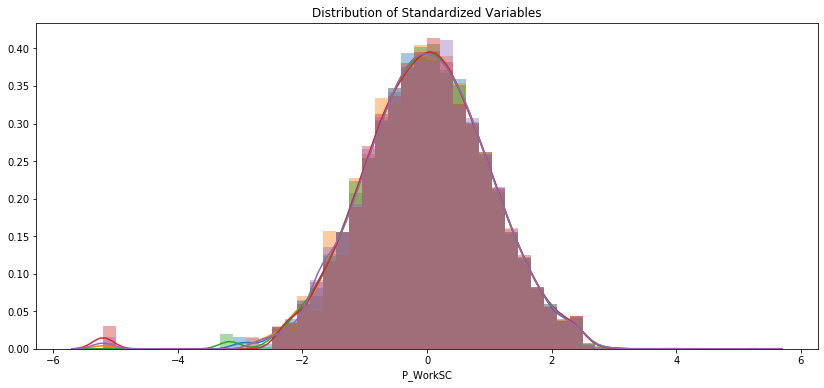

In [68]:
ScaledProdValues = df_database[['P_Motor', 'P_Household', 'P_Health', 'P_Life', 'P_Work']]
qt = QuantileTransformer(n_quantiles=100, output_distribution='normal', random_state=333)
ScaledProdValues = pd.DataFrame(qt.fit_transform(ScaledProdValues), columns = ['P_MotorSC', 'P_HouseholdSC', 'P_HealthSC', 'P_LifeSC', 'P_WorkSC']).set_index(df_database.index)

plt.figure(figsize=(14,6))
sb.distplot(ScaledProdValues['P_MotorSC']).set_title("Distribution of Standardized Variables")
sb.distplot(ScaledProdValues['P_HouseholdSC'])
sb.distplot(ScaledProdValues['P_HealthSC'])
sb.distplot(ScaledProdValues['P_LifeSC'])
sb.distplot(ScaledProdValues['P_WorkSC'])

## 6.2 Define Number of Clusters

### 6.2.1 Elbow Graph

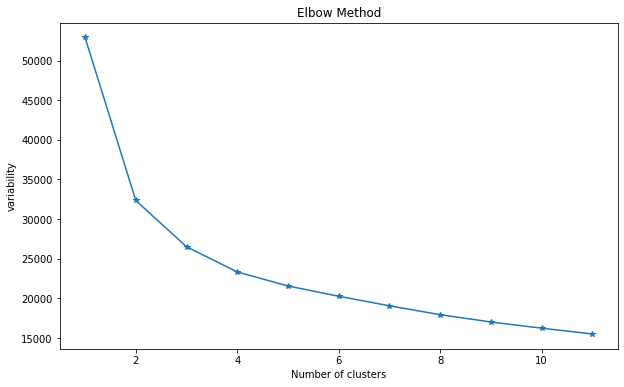

In [69]:
variability = []

for i in range(1, 12):
    kmeans = KMeans(n_clusters=i, max_iter=1000, n_init=20)
    kmeans.fit(ScaledProdValues)
    variability.append(kmeans.inertia_)
plt.figure(figsize=(10,6))
plt.plot(range(1, 12), variability, marker = '*')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('variability')
plt.show()

### 6.2.2 Silhouette Score

In [70]:
n_clusters = [2,3,4,5]
for i in range(0,len(n_clusters)):
    kmeans = KMeans(n_clusters=n_clusters[i], init='k-means++', max_iter=1000, n_init=20)
    kmeans.fit(ScaledProdValues)
    silhouette_avg = silhouette_score(ScaledProdValues, kmeans.labels_)
    print("For", n_clusters[i], "clusters The average silhouette_score is :", round(silhouette_avg,4))

For 2 clusters The average silhouette_score is : 0.3324
For 3 clusters The average silhouette_score is : 0.2496
For 4 clusters The average silhouette_score is : 0.2175
For 5 clusters The average silhouette_score is : 0.196


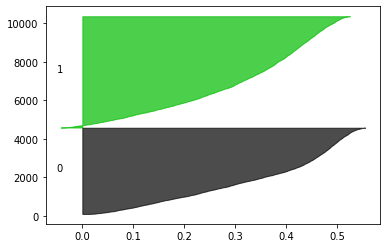

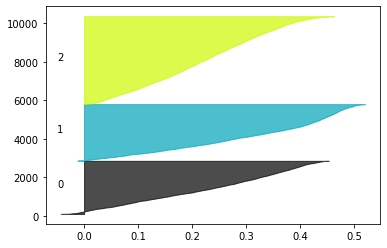

In [71]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=1000, n_init=20, random_state=1998)
kmeans.fit(ScaledProdValues)
sample_silhouette_values = silhouette_samples(ScaledProdValues, kmeans.labels_)
cluster_labels = kmeans.labels_

y_lower = 100
fig = plt.figure()
ax1 = fig.add_subplot(111)
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i=ith_cluster_silhouette_values. shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
    
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=1000, n_init=20, random_state=1998)
kmeans.fit(ScaledProdValues)
sample_silhouette_values = silhouette_samples(ScaledProdValues, kmeans.labels_)
cluster_labels = kmeans.labels_
y_lower = 100
fig = plt.figure()
ax2 = fig.add_subplot(111)
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i=ith_cluster_silhouette_values. shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax2.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
    # Label the silhouette plots with their cluster numbers at the middle
    ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples


### 6.2.3 Factorial Analysis

In [72]:
#Factorial Analysis

#Bartlett’s test of sphericity checks whether or not the observed variables intercorrelate at all using 
#the observed correlation matrix against the identity matrix. If the test found statistically insignificant, 
#you should not employ a factor analysis.
#chi_square_value,p_value=calculate_bartlett_sphericity(ScaledProdValues)
#chi_square_value, p_value

C:\Users\gsmfa\Anaconda3\lib\site-packages\factor_analyzer\factor_analyzer.py:626: UserWarning: No rotation will be performed when the number of factors equals 1.
  warnings.warn('No rotation will be performed when '


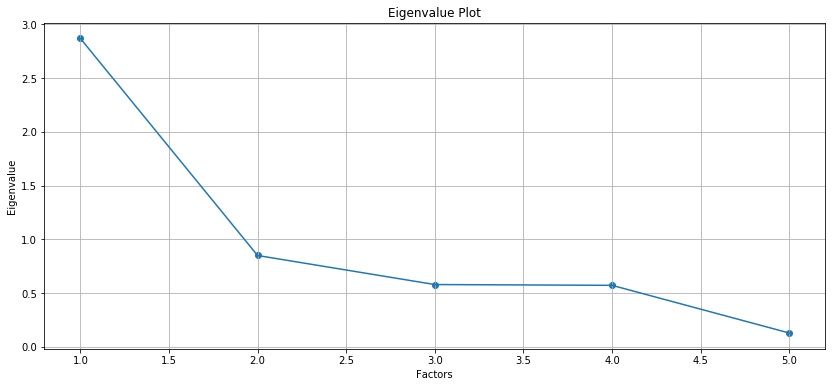

                   Fat1
P_MotorSC     -1.023204
P_HouseholdSC  0.628487
P_HealthSC     0.471586
P_LifeSC       0.640011
P_WorkSC       0.629646


In [73]:

# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors= 1)
fa.fit(ScaledProdValues)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()

#Analysing the egenvalues to dicide the number of factor that we can have Lambda >= 1
plt.figure(figsize=(14,6))
plt.scatter(range(1,ScaledProdValues.shape[1]+1),ev)
plt.plot(range(1,ScaledProdValues.shape[1]+1),ev)
plt.title('Eigenvalue Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

FatAna = pd.DataFrame(fa.loadings_, columns=["Fat1"], index = ScaledProdValues.columns)
print(FatAna)

#### Looking at the factor analysis we only have one egenvalue above 1 and the releations between the variables show us that if the customer spend money in Motor he will spend less money in the others premiums and the other way round as well

#### Looking at the silhouette score, the elbow graph and FA we decide to start our analysis with 2 clusters

## 6.3 Evaluating techniques

### 6.3.1 Kmeans ++

In [74]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=1000, n_init=20, random_state=1998)
Clusters = pd.DataFrame(kmeans.fit_predict(ScaledProdValues),columns = ['ClusterLob'], index = ScaledProdValues.index)

# Hierarchical centroids
CentersLOB_STD = ScaledProdValues.merge(Clusters,left_index=True, right_index=True)
CentersLOB_STD = CentersLOB_STD.groupby('ClusterLob').agg(P_MotorSC=('P_MotorSC', 'mean'), 
                                                          P_HouseholdSC=('P_HouseholdSC', 'mean'),
                                                          P_HealthSC=('P_HealthSC', 'mean'),
                                                          P_LifeSC=('P_LifeSC', 'mean'),
                                                          P_WorkSC=('P_WorkSC', 'mean'),
                                                          size=('ClusterLob', 'size'))
                                                                
CentersLOB = df_database.merge(Clusters,left_index=True, right_index=True)
CentersLOB = CentersLOB.groupby('ClusterLob').agg(P_Motor=('P_Motor', 'mean'), 
                                                                P_Household=('P_Household', 'mean'),
                                                                P_Health=('P_Health', 'mean'),
                                                                P_Life=('P_Life', 'mean'),
                                                                P_Work=('P_Work', 'mean'),
                                                                size=('ClusterLob', 'size'))

#calinski The index is the ratio of the sum of between-clusters dispersion and of inter-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared
silhouette_KM = round(silhouette_score(ScaledProdValues, kmeans.labels_),2)
calinski_KM = round(metrics.calinski_harabasz_score(ScaledProdValues, kmeans.labels_),0)

print(CentersLOB_STD)

            P_MotorSC  P_HouseholdSC  P_HealthSC  P_LifeSC  P_WorkSC  size
ClusterLob                                                                
0            0.862869      -0.685535   -0.595799 -0.749718 -0.708383  4477
1           -0.672348       0.520186    0.457176  0.551830  0.532731  5779


### 6.3.2 Hierarchical

In [75]:
k=2
Hclustering = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
HierarcCluster = pd.DataFrame(Hclustering.fit_predict(ScaledProdValues),columns = ['ClusterLob'], index = ScaledProdValues.index)

# Hierarchical centroids
CentersLOB_STD_HC = ScaledProdValues.merge(HierarcCluster,left_index=True, right_index=True)
CentersLOB_STD_HC = CentersLOB_STD_HC.groupby('ClusterLob').agg(P_MotorSC=('P_MotorSC', 'mean'), 
                                                                P_HouseholdSC=('P_HouseholdSC', 'mean'),
                                                                P_HealthSC=('P_HealthSC', 'mean'),
                                                                P_LifeSC=('P_LifeSC', 'mean'),
                                                                P_WorkSC=('P_WorkSC', 'mean'),
                                                                size=('ClusterLob', 'size'))
                                                                
CentersLOB_HC = df_database.merge(HierarcCluster,left_index=True, right_index=True)
CentersLOB_HC = CentersLOB_HC.groupby('ClusterLob').agg(P_Motor=('P_Motor', 'mean'), 
                                                                P_Household=('P_Household', 'mean'),
                                                                P_Health=('P_Health', 'mean'),
                                                                P_Life=('P_Life', 'mean'),
                                                                P_Work=('P_Work', 'mean'),
                                                                size=('ClusterLob', 'size'))

silhouette_HC = round(silhouette_score(ScaledProdValues, Hclustering.labels_),2)
calinski_HC = round(metrics.calinski_harabasz_score(ScaledProdValues, Hclustering.labels_),0)

print(CentersLOB_STD_HC)

            P_MotorSC  P_HouseholdSC  P_HealthSC  P_LifeSC  P_WorkSC  size
ClusterLob                                                                
0           -0.304487       0.245120    0.252032  0.226995  0.191367  8386
1            1.353472      -1.132922   -1.143803 -1.107507 -0.907795  1870


### 6.3.3 Mean Shift

In [76]:
bandwidth = estimate_bandwidth(ScaledProdValues, quantile=0.5, n_samples=1000)
MeanShiftClustering = MeanShift(bandwidth=bandwidth, bin_seeding=True)
MShiftCluster = pd.DataFrame(MeanShiftClustering.fit_predict(ScaledProdValues),columns = ['ClusterLob'], index = ScaledProdValues.index)


# Mean Shift centroids
CentersLOB_STD_MS = ScaledProdValues.merge(MShiftCluster, left_index=True, right_index=True)
CentersLOB_STD_MS = CentersLOB_STD_MS.groupby('ClusterLob').agg(P_MotorSC=('P_MotorSC', 'mean'), 
                                                                P_HouseholdSC=('P_HouseholdSC', 'mean'),
                                                                P_HealthSC=('P_HealthSC', 'mean'),
                                                                P_LifeSC=('P_LifeSC', 'mean'),
                                                                P_WorkSC=('P_WorkSC', 'mean'),
                                                                size=('ClusterLob', 'size'))
                                                                
CentersLOB_MS = df_database.merge(MShiftCluster,left_index=True, right_index=True)
CentersLOB_MS = CentersLOB_MS.groupby('ClusterLob').agg(P_Motor=('P_Motor', 'mean'), 
                                                                P_Household=('P_Household', 'mean'),
                                                                P_Health=('P_Health', 'mean'),
                                                                P_Life=('P_Life', 'mean'),
                                                                P_Work=('P_Work', 'mean'),
                                                                size=('ClusterLob', 'size'))

    
# Mean Shift scores
silhouette_MS = round(silhouette_score(ScaledProdValues, MeanShiftClustering.labels_),2)
calinski_MS = round(metrics.calinski_harabasz_score(ScaledProdValues, MeanShiftClustering.labels_),0)

print(CentersLOB_STD_MS)

            P_MotorSC  P_HouseholdSC  P_HealthSC  P_LifeSC  P_WorkSC  size
ClusterLob                                                                
0           -0.037190       0.028423    0.042352  0.052565  0.032599  9964
1            1.686916      -0.982533   -1.469493 -3.006942 -1.150446   210
2           -2.532775      -0.814651   -2.105399 -0.583325 -0.973631    33
3            1.813415      -2.536844   -1.526613 -1.109635 -3.138955    46
4           -1.988081       1.241155    0.309413  3.510367  0.173419     3


### 6.3.4 DBScan

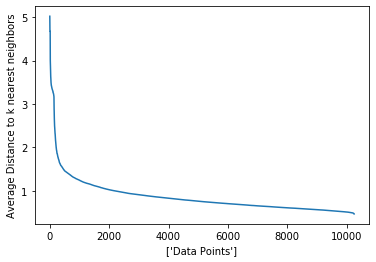

In [77]:
## Estimating radius through N-Neighbors
ns = 100
nbrs = NearestNeighbors(n_neighbors=ns).fit(ScaledProdValues)
distances, indices = nbrs.kneighbors(ScaledProdValues)
distanceDe = sorted(distances[:,ns-1], reverse=True)
plt.plot(distanceDe)

plt.ylabel('Average Distance to k nearest neighbors')
plt.xlabel(['Data Points'])
plt.show() 
    


In [78]:
## DBScan with variables
DBScanClustering = DBSCAN(eps=0.5, min_samples=10).fit(ScaledProdValues)
DBScanCluster = pd.DataFrame(DBScanClustering.fit_predict(ScaledProdValues),columns = ['ClusterLob'], index = ScaledProdValues.index)

CentersLOB_STD_DB = ScaledProdValues.merge(DBScanCluster, left_index=True, right_index=True)
CentersLOB_STD_DB = CentersLOB_STD_DB.groupby('ClusterLob').agg(P_MotorSC=('P_MotorSC', 'mean'), 
                                                                P_HouseholdSC=('P_HouseholdSC', 'mean'),
                                                                P_HealthSC=('P_HealthSC', 'mean'),
                                                                P_LifeSC=('P_LifeSC', 'mean'),
                                                                P_WorkSC=('P_WorkSC', 'mean'),
                                                                size=('ClusterLob', 'size'))
                                                                
CentersLOB_DB = df_database.merge(DBScanCluster,left_index=True, right_index=True)
CentersLOB_DB = CentersLOB_DB.groupby('ClusterLob').agg(P_Motor=('P_Motor', 'mean'), 
                                                                P_Household=('P_Household', 'mean'),
                                                                P_Health=('P_Health', 'mean'),
                                                                P_Life=('P_Life', 'mean'),
                                                                P_Work=('P_Work', 'mean'),
                                                                size=('ClusterLob', 'size'))


# DBSCAN scores
silhouette_DB = round(silhouette_score(ScaledProdValues, DBScanClustering.labels_),2)
calinski_DB = round(metrics.calinski_harabasz_score(ScaledProdValues, DBScanClustering.labels_),0)

print(CentersLOB_STD_DB)

            P_MotorSC  P_HouseholdSC  P_HealthSC  P_LifeSC  P_WorkSC  size
ClusterLob                                                                
-1          -0.468166       0.080273   -0.116366 -0.017630  0.058260  1808
 0           0.101483      -0.022706    0.027861 -0.013847 -0.021444  8425
 1          -2.955802      -1.220640   -3.166940 -1.470545 -1.335178    12
 2          -1.855348       1.997325    0.420538  1.072571  0.924673     5
 3           2.293917      -2.026995   -2.301822 -1.107749 -1.007008     6


In [79]:
ClusterMethod = ['Kmeans++', 'Hierarchial', 'Mean Shift', 'DBSCAN']
NClusters = [len(CentersLOB), len(CentersLOB_HC), len(CentersLOB_MS),len(CentersLOB_DB)]
SilhouetteScore = [silhouette_KM, silhouette_HC, silhouette_MS, silhouette_DB]
CalinskiScore = [calinski_KM, calinski_HC, calinski_MS, calinski_DB]

EvaluateScore = pd.DataFrame({'ClusterMethod': ClusterMethod, 'NClusters': NClusters, 'SilhouetteScore': SilhouetteScore, 'CalinskiScore': CalinskiScore}) 
print(EvaluateScore)

  ClusterMethod  NClusters  SilhouetteScore  CalinskiScore
0      Kmeans++          2             0.33         6520.0
1   Hierarchial          2             0.30         3928.0
2    Mean Shift          5             0.25          270.0
3        DBSCAN          5            -0.03           48.0


#### at the end the best aproach was Kmeans++

## 6.4 applying Kmeans++

In [80]:
# New DF with a cluster column
Cluster_db = df_database.merge(Clusters,left_index=True, right_index=True)

In [81]:
print(CentersLOB_STD)

            P_MotorSC  P_HouseholdSC  P_HealthSC  P_LifeSC  P_WorkSC  size
ClusterLob                                                                
0            0.862869      -0.685535   -0.595799 -0.749718 -0.708383  4477
1           -0.672348       0.520186    0.457176  0.551830  0.532731  5779


In [82]:
print(CentersLOB)

               P_Motor  P_Household    P_Health     P_Life     P_Work  size
ClusterLob                                                                 
0           422.561834    66.387927  122.733444  12.863027  13.050197  4477
1           198.470142   313.312494  201.920716  63.546139  61.743758  5779


#### Looking at the centroids again we basically confirm the Fatorial analysis, we can notice that we have a cluster who spend more in motor and a cluster that spend more in the others products. So we will label this clusters as Motors and Life Care

In [83]:
Cluster_db["ClusterLob"] = Cluster_db["ClusterLob"].replace(to_replace={0:'Motors',1: 'Life Care'})

In [86]:
@interact
def plt_distro(indicator=['P_Motor', 'P_Household', 'P_Health', 'P_Life', 'P_Work']):
    plt.figure(figsize=(12,5))
    return sb.boxplot(x = indicator, y = 'ClusterLob', data =Cluster_db).set_title('Distribution by Cluster')

interactive(children=(Dropdown(description='indicator', options=('P_Motor', 'P_Household', 'P_Health', 'P_Life…

# 7. Clustering Engage Variables

## 7.1 Discrete Variables (KModes)

In [87]:
df_engage = df_database.loc[:,['Children', 'GeographicLivingArea' ,  'EducationalDegree']]

km = KModes(n_clusters=3, init='random', n_init=40, max_iter =600,  verbose=0, random_state = 100)
ClustersEngC = km.fit_predict(df_engage)

# Print the cluster centroids
CentersEngC = pd.DataFrame(km.cluster_centroids_, columns = ['Children', 'GeographicLivingArea', 'EducationalDegree'])
unique, counts = np.unique(km.labels_, return_counts=True)
counts = pd.DataFrame(np.asarray((unique, counts)).T, columns = ['Label','Number'])
CentersEngC = pd.concat([CentersEngC, counts], axis = 1)
ClustersEngC = pd.DataFrame(ClustersEngC, columns = ['ClusterEngageC']).set_index(df_engage.index)

print(CentersEngC)


   Children  GeographicLivingArea  EducationalDegree  Label  Number
0       1.0                   1.0                3.0      0    5947
1       0.0                   4.0                2.0      1    2027
2       1.0                   4.0                2.0      2    2282


In [88]:
Cluster_db = Cluster_db.merge(ClustersEngC ,left_index=True, right_index=True)

In [92]:
@interact
def plt_distro(indicator=['Children', 'GeographicLivingArea', 'EducationalDegree']):
    x = Cluster_db.groupby(['ClusterEngageC', indicator], as_index = False)['CustomerIdentity'].count()
    plt.figure(figsize=(10,5))
    return sb.barplot(x="ClusterEngageC", y="CustomerIdentity", hue=indicator, data=x).set_title('Distribution by Cluester')

interactive(children=(Dropdown(description='indicator', options=('Children', 'GeographicLivingArea', 'Educatio…

#### Taking into account the distribution of discrete variables, we label the clusters as  0 = Has Kids and BSc/MSc', 1 = 'No kids' and 2 = 'Has Kids and High-School.

In [93]:
Cluster_db["ClusterEngageC"] = Cluster_db["ClusterEngageC"].replace(to_replace={0:'Has Kids and BSc/MSc',1:'No kids', 2:'Has Kids and High-School'})

## 7.2 Numerical Variables (KMeans)

### 7.2.1 Selecting Variables

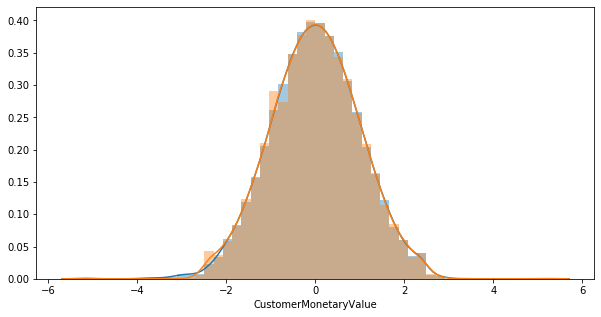

In [94]:
EngageNumeric = df_database[['GrossMonthlySalary', 'CustomerMonetaryValue']]

qt = QuantileTransformer(n_quantiles=100, output_distribution='normal', random_state=333)
EngageNumeric = pd.DataFrame(qt.fit_transform(EngageNumeric), columns = ['GrossMonthlySalary', 'CustomerMonetaryValue']).set_index(df_database.index)

plt.figure(figsize=(10,5))
sb.distplot(EngageNumeric['GrossMonthlySalary'])
sb.distplot(EngageNumeric['CustomerMonetaryValue'])

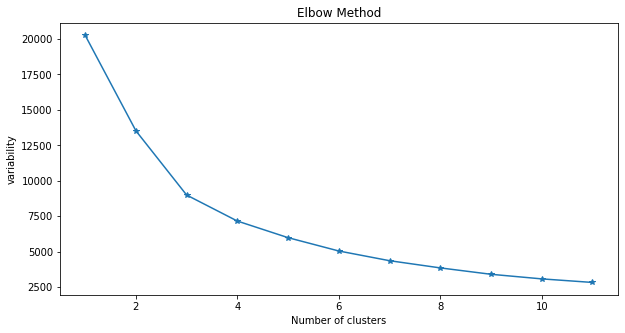

In [95]:
###Elbow Graph
variability = []
for i in range(1, 12):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=20)
    kmeans.fit(EngageNumeric)
    variability.append(kmeans.inertia_)
plt.figure(figsize=(10,5))
plt.plot(range(1, 12), variability, marker = '*')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('variability')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.3194058823496944
For n_clusters = 3 The average silhouette_score is : 0.3450095257988033
For n_clusters = 4 The average silhouette_score is : 0.32431151137853215
For n_clusters = 5 The average silhouette_score is : 0.3223881210647494
For n_clusters = 6 The average silhouette_score is : 0.3347190249142602


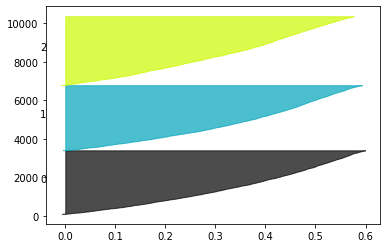

In [96]:

#5.4 silhouette value and Plot
n_clusters = [2,3,4,5,6]
for i in range(0,len(n_clusters)):
    kmeans = KMeans(n_clusters=n_clusters[i], init='k-means++', max_iter=1000, n_init=20)
    kmeans.fit(EngageNumeric)
    silhouette_avg = silhouette_score(EngageNumeric, kmeans.labels_)
    print("For n_clusters =", n_clusters[i], "The average silhouette_score is :", silhouette_avg)

    
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=1000, n_init=20, random_state=1998)
kmeans.fit(EngageNumeric)
sample_silhouette_values = silhouette_samples(EngageNumeric, kmeans.labels_)
cluster_labels = kmeans.labels_
import matplotlib.cm as cm
y_lower = 100
fig = plt.figure()
ax1 = fig.add_subplot(111)
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i=ith_cluster_silhouette_values. shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
    

In [97]:
####### 5.5 Clustering

kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=1000, n_init=20, random_state=1998)
ClustersEngN = pd.DataFrame(kmeans.fit_predict(EngageNumeric), index = EngageNumeric.index)
ClustersEngN.rename(columns = {0: 'ClusterEngageN'}, inplace = True)
Cluster_ScaledE = EngageNumeric.merge(ClustersEngN, left_index=True, right_index=True)
Cluster_db = Cluster_db.merge(ClustersEngN ,left_index=True, right_index=True)
CentersEngN_STD = Cluster_ScaledE.groupby('ClusterEngageN')['GrossMonthlySalary', 'CustomerMonetaryValue'].mean()
CentersEngN = Cluster_db.groupby('ClusterEngageN')['GrossMonthlySalary', 'CustomerMonetaryValue'].mean()


C:\Users\gsmfa\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
C:\Users\gsmfa\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if __name__ == '__main__':


In [98]:
print(CentersEngN_STD)

                GrossMonthlySalary  CustomerMonetaryValue
ClusterEngageN                                           
0                         1.052795              -0.196656
1                        -0.349489               1.007723
2                        -0.651991              -0.767502


In [99]:
print(CentersEngN)

                GrossMonthlySalary  CustomerMonetaryValue
ClusterEngageN                                           
0                      3577.544602             153.477883
1                      2141.013930             490.408056
2                      1829.592168              18.371460


C:\Users\gsmfa\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


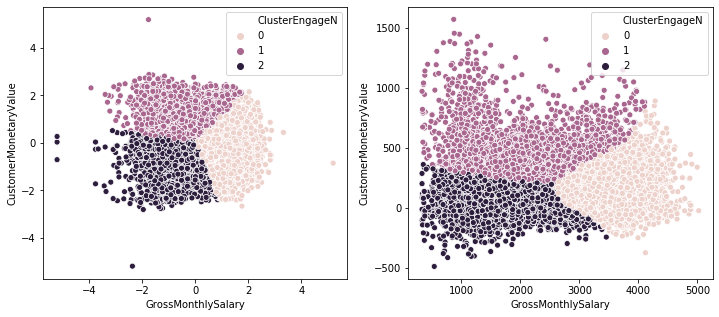

In [112]:
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax1 = sb.scatterplot(x='GrossMonthlySalary', y='CustomerMonetaryValue' , hue='ClusterEngageN', data = Cluster_ScaledE, ax=ax[0])
ax2 = sb.scatterplot(x='GrossMonthlySalary', y='CustomerMonetaryValue' , hue='ClusterEngageN', data = Cluster_db, ax=ax[1])
fig.show()

#### Taking into account the distribution of Salary and Monetary Value, we label the clusters as 0 = 'Silver - High Wages', 1 = 'Gold - AVG wages' and 2 = 'Broze - AVG wages'.

In [113]:
Cluster_db["ClusterEngageN"] = Cluster_db["ClusterEngageN"].replace(to_replace={1:'Gold - AVG wages',2:'Broze - AVG wages', 0:'Silver - High Wages'})

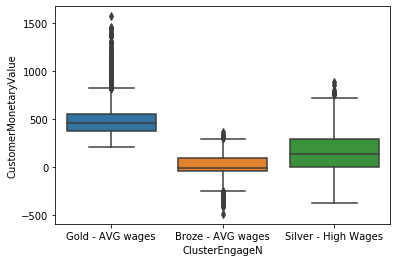

In [114]:
sb.boxplot(x='ClusterEngageN', y='CustomerMonetaryValue', data = Cluster_db)


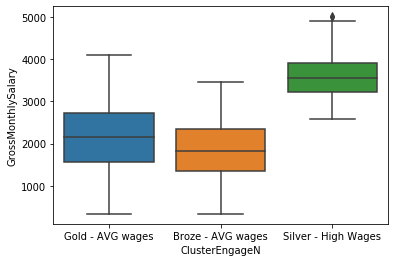

In [115]:
sb.boxplot(x='ClusterEngageN', y='GrossMonthlySalary', data = Cluster_db)

# 8. Evaluating Clusters

##### Now We will join the 3 segmantations and discribe the customers based on it. After that we appyed a decision tree to check if the clusters are well divided

In [116]:
Cluster_Matrix = Cluster_db.groupby(['ClusterLob', 'ClusterEngageC', 'ClusterEngageN'], as_index = False)['CustomerIdentity'].count()

Cluster_Matrix = pd.pivot_table(Cluster_Matrix, values='CustomerIdentity', index=['ClusterLob', 'ClusterEngageN'], columns=['ClusterEngageC'], aggfunc=np.sum)
Cluster_db['FinalCluster'] = Cluster_db['ClusterLob']+' / '+ Cluster_db['ClusterEngageN']+' / '+Cluster_db['ClusterEngageC'] 

#Decision tree to try to reproduce de clusters that we have

x = Cluster_db.loc[:,['P_Motor', 'P_Household', 'P_Health', 'P_Life', 'P_Work', 
                        'GrossMonthlySalary', 'CustomerMonetaryValue', 'EducationalDegree',  
                        'GeographicLivingArea', 'Children']]

y = Cluster_db.loc[:,['FinalCluster']]


y = pd.Categorical(pd.Series(y['FinalCluster']), ordered = True)
y = pd.get_dummies(y)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=111, train_size = 0.4)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
FinalCluster = np.array(y_test).argmax(axis=1)
predictions = np.array(y_pred).argmax(axis=1)
Confusion_Matrix = pd.DataFrame(confusion_matrix(FinalCluster, predictions), columns = y.columns, index = y.columns)
print("Accuracy:", round(metrics.accuracy_score(FinalCluster, predictions), 2))
print("Balanced Accuracy:", round(metrics.balanced_accuracy_score(FinalCluster, predictions), 2))
Confusion_Matrix

Accuracy: 0.85
Balanced Accuracy: 0.82


,Life Care / Broze - AVG wages / Has Kids and BSc/MSc,Life Care / Broze - AVG wages / Has Kids and High-School,Life Care / Broze - AVG wages / No kids,Life Care / Gold - AVG wages / Has Kids and BSc/MSc,Life Care / Gold - AVG wages / Has Kids and High-School,Life Care / Gold - AVG wages / No kids,Life Care / Silver - High Wages / Has Kids and BSc/MSc,Life Care / Silver - High Wages / Has Kids and High-School,Life Care / Silver - High Wages / No kids,Motors / Broze - AVG wages / Has Kids and BSc/MSc,Motors / Broze - AVG wages / Has Kids and High-School,Motors / Broze - AVG wages / No kids,Motors / Gold - AVG wages / Has Kids and BSc/MSc,Motors / Gold - AVG wages / Has Kids and High-School,Motors / Gold - AVG wages / No kids,Motors / Silver - High Wages / Has Kids and BSc/MSc,Motors / Silver - High Wages / Has Kids and High-School,Motors / Silver - High Wages / No kids
Life Care / Broze - AVG wages / Has Kids and BSc/MSc,566,6,0,16,0,0,19,0,1,40,0,0,2,0,0,3,0,0
Life Care / Broze - AVG wages / Has Kids and High-School,1,352,0,0,13,0,0,14,0,2,29,0,1,2,0,0,3,0
Life Care / Broze - AVG wages / No kids,0,0,139,1,0,7,0,0,9,0,0,4,0,0,0,0,0,2
Life Care / Gold - AVG wages / Has Kids and BSc/MSc,15,0,0,427,4,10,21,0,1,5,0,0,35,0,0,3,0,0
Life Care / Gold - AVG wages / Has Kids and High-School,1,13,0,1,300,0,0,6,0,0,1,0,1,12,0,0,0,0
Life Care / Gold - AVG wages / No kids,1,0,2,13,3,139,1,0,12,0,0,0,0,0,2,0,0,4
Life Care / Silver - High Wages / Has Kids and BSc/MSc,9,0,0,25,0,0,381,1,4,4,0,0,0,0,0,35,2,0
Life Care / Silver - High Wages / Has Kids and High-School,0,14,0,2,10,1,1,125,0,0,1,0,0,1,0,0,6,0
Life Care / Silver - High Wages / No kids,0,0,2,0,2,8,0,0,563,0,0,1,0,0,1,1,0,34
Motors / Broze - AVG wages / Has Kids and BSc/MSc,45,0,0,3,0,0,2,0,0,617,0,1,3,0,0,25,0,0


   Looking at the table with the cluster and Average per product, wages and value
 we decide to put some groups together, we didn't find a reason to have to groups
 of costumers without kids just split by education. they have the same behaivor inside their 
 groups


   Other caracteristic that we found was if the clients don't has kids they usually don't spend 
money with Motor, we can notice that looking the size of the cluster of clientas without kids
we only have 8% of costumers (Gold and Bronze) Spending more money with motors than with life care
we will keep this costumers in motors but toguether with the costumers who has kids

In [119]:
Mean_Prod = Cluster_db.groupby('FinalCluster', as_index = False)['P_Motor', 'P_Household', 'P_Health', 'P_Life', 'P_Work', 'GrossMonthlySalary', 'CustomerMonetaryValue'].mean()


Cluster_db.loc[Cluster_db['ClusterEngageC'] == 'Has Kids and High-School', 'ClusterEngageC'] = 'Has Kids'
Cluster_db.loc[Cluster_db['ClusterEngageC'] == 'Has Kids and BSc/MSc', 'ClusterEngageC'] = 'Has Kids'

Cluster_db.loc[Cluster_db['FinalCluster'] == 'Motor / Broze - AVG wages / No kids', 'ClusterEngageC'] = 'Has Kids'
Cluster_db.loc[Cluster_db['FinalCluster'] == 'Motor / Gold - AVG wages / No kids', 'ClusterEngageC'] = 'Has Kids'


Cluster_db.drop(columns = ['FinalCluster'])
Cluster_db['FinalCluster'] = Cluster_db['ClusterLob']+' / '+ Cluster_db['ClusterEngageN']+' / '+Cluster_db['ClusterEngageC']


Cluster_Matrix = Cluster_db.groupby(['ClusterLob', 'ClusterEngageC', 'ClusterEngageN'], as_index = False)['CustomerIdentity'].count()
Cluster_Matrix = pd.pivot_table(Cluster_Matrix, values='CustomerIdentity', index=['ClusterLob', 'ClusterEngageN'], columns=['ClusterEngageC'], aggfunc=np.sum)

Mean_Prod = Cluster_db.groupby('FinalCluster', as_index = False)['P_Motor', 'P_Household', 'P_Health', 'P_Life', 'P_Work', 'GrossMonthlySalary', 'CustomerMonetaryValue'].mean()


C:\Users\gsmfa\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
C:\Users\gsmfa\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [120]:
#Avaliando a reclusterização


x = Cluster_db.loc[:,['P_Motor', 'P_Household', 'P_Health', 'P_Life', 'P_Work', 
                        'GrossMonthlySalary', 'CustomerMonetaryValue', 'EducationalDegree',  
                        'GeographicLivingArea', 'Children']]

y = Cluster_db.loc[:,['FinalCluster']]


y = pd.Categorical(pd.Series(y['FinalCluster']), ordered = True)
y = pd.get_dummies(y)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=111, train_size = 0.4)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
FinalCluster = np.array(y_test).argmax(axis=1)
predictions = np.array(y_pred).argmax(axis=1)
Confusion_Matrix = pd.DataFrame(confusion_matrix(FinalCluster, predictions), columns = y.columns, index = y.columns)
print("Accuracy:", round(metrics.accuracy_score(FinalCluster, predictions), 2))
print("Balanced Accuracy:", round(metrics.balanced_accuracy_score(FinalCluster, predictions), 2))


Accuracy: 0.88
Balanced Accuracy: 0.83


In [121]:
Mean_Prod = Cluster_db.groupby('FinalCluster').agg(P_Motor=('P_Motor', 'mean'), 
                                                                P_Household=('P_Household', 'mean'),
                                                                P_Health=('P_Health', 'mean'),
                                                                P_Life=('P_Life', 'mean'),
                                                                P_Work=('P_Work', 'mean'),
                                                                GrossMonthlySalary=('GrossMonthlySalary', 'mean'),
                                                                CustomerMonetaryValue=('CustomerMonetaryValue', 'mean'),
                                                                FirstPolicy=('FirstPolicy', 'mean'),
                                                                ClaimsRate=('ClaimsRate', 'mean'),
                                                                size=('ClusterLob', 'size'))
Mean_Prod

,P_Motor,P_Household,P_Health,P_Life,P_Work,GrossMonthlySalary,CustomerMonetaryValue,FirstPolicy,ClaimsRate,size
FinalCluster,,,,,,,,,,
Life Care / Broze - AVG wages / Has Kids,182.762324,295.236026,208.091944,68.592993,67.828418,1577.015873,42.403458,1985.922902,0.910476,1764
Life Care / Broze - AVG wages / No kids,141.471587,390.458856,182.556384,99.737085,87.224317,1466.863469,32.393137,1985.870849,0.928044,271
Life Care / Gold - AVG wages / Has Kids,199.236636,393.089464,183.225893,64.352029,65.177521,1849.787857,517.701729,1986.005000,0.411043,1400
Life Care / Gold - AVG wages / No kids,165.116826,507.801706,172.043515,79.664573,72.256860,2331.767918,638.733379,1985.938567,0.342355,293
Life Care / Silver - High Wages / Has Kids,244.317473,222.565403,202.525695,48.691992,47.838367,3508.173955,164.551273,1986.172012,0.750146,1029
Life Care / Silver - High Wages / No kids,203.047172,250.382828,229.969579,54.469403,50.767701,3734.593933,157.695851,1986.450098,0.766507,1022
Motors / Broze - AVG wages / Has Kids,428.637769,54.639079,118.304617,11.821418,11.931317,2173.645161,-11.408434,1985.814516,0.978347,1488
Motors / Broze - AVG wages / No kids,423.601154,62.255769,108.242692,19.146731,13.150000,2442.923077,-17.779231,1985.057692,0.975385,52
Motors / Gold - AVG wages / Has Kids,436.814456,66.433469,113.808438,11.637587,11.881244,2334.139375,441.290763,1986.011875,0.267400,1600


In order to generate marketing strategies, we put together groups that we thought should have the same kind of approach. and that made the number of clusters decrease to 5.


<strong>Profitable Life Care Focused:</strong> Basically the best customers in 'Life Care', has the biggest CMV and invest more than the average in premiums related with Life, Household, Work and Health

<strong>Profitable Motor Focused:</strong> Best customers in 'Motors', CMV two times above the average, composed mostly of people with children.

<strong>Wealthy Live Care Focused:</strong> High-income clients with below-average CMV. Are focused on Life Care  

<strong>Wealthy Motor Focused:</strong> High-income clients with below-average CMV. Are focused on Motors

<strong>Unprofitable:</strong> Customers with low monetary value.


In [123]:
Cluster_db.loc[Cluster_db['FinalCluster'] == 'Life Care / Broze - AVG wages / Has Kids', 'Marketing'] = 'Unprofitable'
Cluster_db.loc[Cluster_db['FinalCluster'] == 'Life Care / Broze - AVG wages / No kids', 'Marketing'] = 'Unprofitable'
Cluster_db.loc[Cluster_db['FinalCluster'] == "Motors / Broze - AVG wages / Has Kids", 'Marketing'] = 'Unprofitable'
Cluster_db.loc[Cluster_db['FinalCluster'] == "Motors / Broze - AVG wages / No kids", 'Marketing'] = 'Unprofitable'

Cluster_db.loc[Cluster_db['FinalCluster'] == "Motors / Gold - AVG wages / Has Kids", 'Marketing'] = 'Profitable Motor Focused'
Cluster_db.loc[Cluster_db['FinalCluster'] == "Motors / Gold - AVG wages / No kids", 'Marketing'] = 'Profitable Motor Focused'

Cluster_db.loc[Cluster_db['FinalCluster'] == "Life Care / Gold - AVG wages / Has Kids", 'Marketing'] = 'Profitable Life Care Focused'
Cluster_db.loc[Cluster_db['FinalCluster'] == "Life Care / Gold - AVG wages / No Kids", 'Marketing'] = 'Profitable Life Care Focused'

Cluster_db.loc[Cluster_db['FinalCluster'] == "Life Care / Silver - High Wages / Has Kids", 'Marketing'] = 'Wealthy Live Care Focused'
Cluster_db.loc[Cluster_db['FinalCluster'] == "Life Care / Silver - High Wages / No kids", 'Marketing'] = 'Wealthy Live Care Focused'
Cluster_db.loc[Cluster_db['FinalCluster'] == "Motors / Silver - High Wages / Has Kids", 'Marketing'] = 'Wealthy Motor Focused'
Cluster_db.loc[Cluster_db['FinalCluster'] == "Motors / Silver - High Wages / No kids", 'Marketing'] = 'Wealthy Motor Focused'

Mean_Prod = Cluster_db.groupby('Marketing').agg(P_Motor=('P_Motor', 'mean'), 
                                                                P_Household=('P_Household', 'mean'),
                                                                P_Health=('P_Health', 'mean'),
                                                                P_Life=('P_Life', 'mean'),
                                                                P_Work=('P_Work', 'mean'),
                                                                GrossMonthlySalary=('GrossMonthlySalary', 'mean'),
                                                                CustomerMonetaryValue=('CustomerMonetaryValue', 'mean'),
                                                                FirstPolicy=('FirstPolicy', 'mean'),
                                                                ClaimsRate=('ClaimsRate', 'mean'),
                                                                size=('ClusterLob', 'size'))
Mean_Prod

,P_Motor,P_Household,P_Health,P_Life,P_Work,GrossMonthlySalary,CustomerMonetaryValue,FirstPolicy,ClaimsRate,size
Marketing,,,,,,,,,,
Profitable Life Care Focused,199.236636,393.089464,183.225893,64.352029,65.177521,1849.787857,517.701729,1986.005000,0.411043,1400
Profitable Motor Focused,436.381844,67.559578,113.731440,11.814027,12.056187,2350.309340,441.823605,1985.983343,0.267662,1681
Unprofitable,285.474629,198.923343,167.332269,46.604948,45.237684,1829.592168,18.371460,1985.861259,0.941001,3575
Wealthy Live Care Focused,223.752750,236.426646,216.200804,51.570839,49.298035,3620.997562,161.135261,1986.310580,0.758298,2051
Wealthy Motor Focused,396.824196,78.909912,140.628336,15.240836,15.701975,3506.587580,140.973678,1986.095541,0.741401,1256


In [124]:
@interact
def plt_distro(indicator=['Children', 'GeographicLivingArea', 'EducationalDegree']):
    x = Cluster_db.groupby(['Marketing', indicator], as_index = False)['CustomerIdentity'].count()
    plt.figure(figsize=(12,7))
    return sb.barplot(x="Marketing", y="CustomerIdentity", hue=indicator, data=x)

interactive(children=(Dropdown(description='indicator', options=('Children', 'GeographicLivingArea', 'Educatio…

In [125]:
@interact
def plt_distro(indicator=['P_Motor', 'P_Household', 'P_Health', 'P_Life', 'P_Work', 'FirstPolicy' 
                          ,'GrossMonthlySalary', 'CustomerMonetaryValue', 'ClaimsRate']):
    plt.figure(figsize=(15,7))
    return sb.boxplot(data = Cluster_db, x = indicator , y= 'Marketing') 

interactive(children=(Dropdown(description='indicator', options=('P_Motor', 'P_Household', 'P_Health', 'P_Life…

# 9 Suggested Marketing Approach
 
##### 9.1 Profitable Life Care Focused
Although it is not the company’s biggest segment it is highly profitable, and thus it is of great importance that these customers are being kept satisfied. Since this segment is already profitable and customers purchased a lot of insurance, we majorly want to focus on keeping these customers and growing this segment.
In order to make these customers feel save and well taken care off we suggest a relationship marketing approach. Personally, follow-up on their problems and newly signed contracts and offering personalized specials could strengthen the relationship. 
Further, customers might be able to attract new customers with similar insurance spending habits and needs to grow this segment. Through their social surroundings a positive mouth-to-mouth marketing could be very successful, since satisfied customers are likely to refer services to relatives or friends. Hence, making use of the satisfied customer with incentives, such as referral discounts, might increase such reference. Moreover, as there are also families within this segment, it is suggested to also focus on the children, because they can become the future customers once getting into adulthood. Thus, informing the children at the right time with a personalized approach about their possibilities with the insurance company might increase the customer base. However, the children do not necessarily have the same spending habits.
 
##### 9.2 Profitable Motor Focused
As with the profitable life care focused segment these customers are highly profitable and of great importance for the insurance company. Also, these customers should be kept satisfied and kept, while growing this segment.
They should fell save and well taken care off with a personalized marketing approach, incentivizing referrals within their social surroundings. Also, their kids should be paid attention to, since they could be future customers.
In addition to the approach that also has been used in the profitable life care focused segments these customers could be promoted to purchase more non-Motor insurances, since these products are significantly less present.
 
##### 9.3 Unprofitable
This segment currently does not generate any profit. Customers in this segment have high claim rates and pay low premiums. Hence, their behavior either has to be changes to purchase more insurance or they should be tried to be repelled.
As it is the largest segment of the company it should first be focused on being made more profitable by either increasing their premiums or trying to lower the claims rate. Through initial discounts on more expensive premium packages, customers could be moved to spend more. At the same time incentivizing good behavior by lowering the premiums if customers claim less would reduce the claims rate.
If all approaches don’t result in higher profitability for the extreme customers as a last resort the insurance company should take into consideration to end providing services to that customer.
 
##### 9.4 Wealthy Live Care Focused
It is the second biggest segment with big potential. Although these customers have relatively high claims rates decrease the profits, they have the highest income of all segments. Their premiums are more average compared to the other segment and their financial situation indicates a potential for higher premiums that could balance the claims rates increasing profitability.
These customers could be offered additional insurance in areas they have not purchased yet to much. For example, comparing the wealthy motor focused these customers don’t spent as much on Motor insurance. Next to offering additional insurance, a superior insurance should be offered providing the feeling of an elite service, which could further increase the profits.
 
##### 9.5 Wealthy Motor Focused
Just like the wealthy live care focused this segment has the same characteristics with the difference that customers here spend a lot on their Motor insurance, while not spending too much in the other insurance options. 
Thus, next to offering a superior insurance at an additional cost, these customers should be incentivized to purchase additional insurance in the other areas. Appealing to preference of motor related behavior, such as a motor sport, a high-value health insurance might be interesting for the customer to purchase.
